### Name: Hafiza Asifa Naseer (ha5375na-s)
Python in Jupyter Notebook over VS Code

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb, pymc as pm, arviz as az
print("Bambi:", bmb.__version__)
print("PyMC:", pm.__version__)
print("ArviZ:", az.__version__)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Bambi: 0.13.0
PyMC: 5.10.4
ArviZ: 0.17.1


### Load and Wrangle the data

In [2]:
print("="*60)
print("BAYESIAN META-ANALYSIS: HOTEL TOWEL REUSE STUDIES")
print("="*60)

data_file = "towelData.csv"
data = pd.read_csv(data_file, sep=';', encoding='latin1')
count = data.iloc[:, -1]  # get the last column with counts

# Extract data for control and social norm groups
control_yes = count[::4].to_numpy()   # every 4th starting from 0 - control + yes
control_no = count[2::4].to_numpy()   # every 4th starting from 2 - control + no
control_total = np.array([y + n for y, n in zip(control_yes, control_no)])

social_yes = count[1::4].to_numpy()   # every 4th starting from 1 - social norm + yes
social_no = count[3::4].to_numpy()    # every 4th starting from 3 - social norm + no
social_total = np.array([y + n for y, n in zip(social_yes, social_no)])

study = np.arange(1, len(control_yes) + 1)  # study IDs

# Create long format dataframe
control_data = pd.DataFrame({
    "reuse": control_yes, 
    "total": control_total, 
    "group": "control", 
    "study": study
})

social_data = pd.DataFrame({
    "reuse": social_yes, 
    "total": social_total, 
    "group": "social", 
    "study": study
})

combined_data = pd.concat([control_data, social_data], ignore_index=True)

# Convert data types for bambi
combined_data['reuse'] = combined_data['reuse'].astype(int)
combined_data['total'] = combined_data['total'].astype(int)
combined_data['group'] = combined_data['group'].astype('category')
combined_data['study'] = combined_data['study'].astype('category')

print(f"Data summary: {len(study)} studies, {combined_data['total'].sum()} total participants")
print(f"\nData structure:")
print(combined_data.head(10))

# Calculate observed effect sizes for visualization
combined_data['prop'] = combined_data['reuse'] / combined_data['total']
print(f"\nProportion reuse by group:")
print(combined_data.groupby('group')['prop'].describe())

BAYESIAN META-ANALYSIS: HOTEL TOWEL REUSE STUDIES
Data summary: 7 studies, 4494 total participants

Data structure:
   reuse  total    group study
0     74    211  control     1
1    103    277  control     2
2     77    135  control     3
3     82    187  control     4
4     21     25  control     5
5    123    147  control     6
6     28     30  control     7
7     98    222   social     1
8    587   1318   social     2
9    406    655   social     3

Proportion reuse by group:
         count      mean       std       min       25%       50%       75%  \
group                                                                        
control    7.0  0.620213  0.245986  0.350711  0.405172  0.570370  0.838367   
social     7.0  0.638165  0.182631  0.441441  0.473136  0.619847  0.792298   

              max  
group              
control  0.933333  
social   0.875000  


/var/folders/6n/0ytpc3591y540__d6t0cmv_h0000gn/T/ipykernel_23886/2942319975.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(combined_data.groupby('group')['prop'].describe())


#### Quick EDA - Hotel Towel Reuse Bayesian Meta-Analysis


EXPLORATORY DATA ANALYSIS

Reuse rates by group:
         count      mean       std       min       25%       50%       75%  \
group                                                                        
control    7.0  0.620213  0.245986  0.350711  0.405172  0.570370  0.838367   
social     7.0  0.638165  0.182631  0.441441  0.473136  0.619847  0.792298   

              max  
group              
control  0.933333  
social   0.875000  


/var/folders/6n/0ytpc3591y540__d6t0cmv_h0000gn/T/ipykernel_23886/2553341709.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(combined_data.groupby('group')['reuse_rate'].describe())


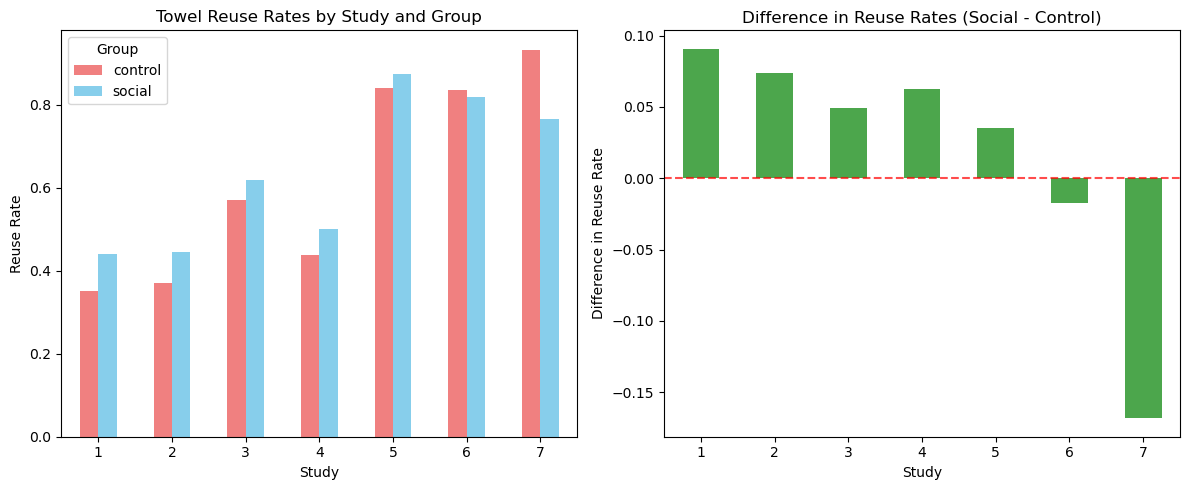


Overall difference in reuse rates: 0.018 ± 0.089
Studies showing positive effect: 5 out of 7


In [3]:
# Exploratory Data Analysis
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Calculate reuse rates by group and study
combined_data['reuse_rate'] = combined_data['reuse'] / combined_data['total']

# Summary statistics
print("\nReuse rates by group:")
print(combined_data.groupby('group')['reuse_rate'].describe())

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Reuse rates by study and group
pivot_data = combined_data.pivot(index='study', columns='group', values='reuse_rate')
pivot_data.plot(kind='bar', ax=axes[0], color=['lightcoral', 'skyblue'])
axes[0].set_title('Towel Reuse Rates by Study and Group')
axes[0].set_xlabel('Study')
axes[0].set_ylabel('Reuse Rate')
axes[0].legend(title='Group')
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Difference in reuse rates (Social - Control)
differences = pivot_data['social'] - pivot_data['control']
differences.plot(kind='bar', ax=axes[1], color='green', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1].set_title('Difference in Reuse Rates (Social - Control)')
axes[1].set_xlabel('Study')
axes[1].set_ylabel('Difference in Reuse Rate')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print(f"\nOverall difference in reuse rates: {differences.mean():.3f} ± {differences.std():.3f}")
print(f"Studies showing positive effect: {sum(differences > 0)} out of {len(differences)}")


### Bayesian Hierarchical Model Formulation

In [14]:
study_data = pd.DataFrame({
    "Study": np.arange(1, len(social_yes) + 1),
    "Social_Yes":   np.asarray(social_yes,   dtype=float),
    "Social_No":    np.asarray(social_no,    dtype=float),
    "Control_Yes":  np.asarray(control_yes,  dtype=float),
    "Control_No":   np.asarray(control_no,   dtype=float),
})

# sanity checks
assert len({len(social_yes), len(social_no), len(control_yes), len(control_no)}) == 1, \
    "Input arrays must all have the same length."
n_studies = len(social_yes)

def calculate_log_or(a, b, c, d):
    return np.log((a + 0.5) * (d + 0.5) / ((b + 0.5) * (c + 0.5)))

def calculate_log_or_se(a, b, c, d):
    return np.sqrt(1/(a + 0.5) + 1/(b + 0.5) + 1/(c + 0.5) + 1/(d + 0.5))

study_log_ors, study_se, study_weights = [], [], []

for i in range(n_studies):
    a, b = social_yes[i],  social_no[i]
    c, d = control_yes[i], control_no[i]
    log_or = calculate_log_or(a, b, c, d)
    se     = calculate_log_or_se(a, b, c, d)
    weight = 1 / se**2
    study_log_ors.append(log_or)
    study_se.append(se)
    study_weights.append(weight)

study_log_ors = np.array(study_log_ors)
study_se      = np.array(study_se)
study_weights = np.array(study_weights)

print("\nIndividual study effects (log OR ± SE):")
for i in range(n_studies):
    print(f"Study {i+1}: {study_log_ors[i]:.3f} ± {study_se[i]:.3f}")


Individual study effects (log OR ± SE):
Study 1: 0.379 ± 0.197
Study 2: 0.303 ± 0.136
Study 3: 0.207 ± 0.191
Study 4: 0.250 ± 0.170
Study 5: 0.251 ± 0.775
Study 6: -0.109 ± 0.246
Study 7: -1.264 ± 0.690


In [8]:
# 2. BAYESIAN RANDOM EFFECTS META-ANALYSIS
print("\n" + "="*60)
print(" BAYESIAN RANDOM EFFECTS META-ANALYSIS")
print("-" * 40)

# Simple Bayesian approach using conjugate priors
# We'll use a normal-normal conjugate model for the effect sizes

# Prior specifications (weakly informative)
prior_mean_mu = 0.0      # No prior belief about overall effect
prior_var_mu = 4.0       # Wide prior variance
prior_a_tau = 1.0        # Shape parameter for tau precision prior
prior_b_tau = 1.0        # Rate parameter for tau precision prior

def bayesian_meta_analysis_mcmc(log_ors, se, n_samples=10000):
    """
    Simple MCMC for Bayesian random effects meta-analysis
    """
    n_studies = len(log_ors)
    
    # Storage for samples
    mu_samples = []
    tau_samples = []
    theta_samples = [[] for _ in range(n_studies)]
    
    # Initial values
    mu = 0.0
    tau = 1.0
    theta = log_ors.copy()
    
    # MCMC sampling
    for iteration in range(n_samples + 1000):  # 1000 burn-in
        
        # Sample mu (overall effect) from normal distribution
        precision_mu = 1/prior_var_mu + n_studies/tau**2
        mean_mu = (prior_mean_mu/prior_var_mu + np.sum(theta)/tau**2) / precision_mu
        mu = np.random.normal(mean_mu, 1/np.sqrt(precision_mu))
        
        # Sample tau (between-study SD) from inverse gamma
        shape = prior_a_tau + n_studies/2
        rate = prior_b_tau + 0.5 * np.sum((theta - mu)**2)
        tau_precision = np.random.gamma(shape, 1/rate)
        tau = 1/np.sqrt(tau_precision)
        
        # Sample study-specific effects theta_i
        for i in range(n_studies):
            precision_theta = 1/se[i]**2 + 1/tau**2
            mean_theta = (log_ors[i]/se[i]**2 + mu/tau**2) / precision_theta
            theta[i] = np.random.normal(mean_theta, 1/np.sqrt(precision_theta))
        
        # Store samples after burn-in
        if iteration >= 1000:
            mu_samples.append(mu)
            tau_samples.append(tau)
            for i in range(n_studies):
                theta_samples[i].append(theta[i])
    
    return np.array(mu_samples), np.array(tau_samples), [np.array(t) for t in theta_samples]

print("Running MCMC sampling...")
mu_posterior, tau_posterior, theta_posterior = bayesian_meta_analysis_mcmc(study_log_ors, study_se)

print("MCMC completed successfully!")


 BAYESIAN RANDOM EFFECTS META-ANALYSIS
----------------------------------------
Running MCMC sampling...
MCMC completed successfully!


In [9]:
# 3. PARAMETER ESTIMATION
print("\n" + "="*60)
print("PARAMETER ESTIMATES")
print("-" * 40)

# Calculate posterior summaries
mu_mean = np.mean(mu_posterior)
mu_hdi = np.percentile(mu_posterior, [5, 95])
tau_mean = np.mean(tau_posterior)
tau_hdi = np.percentile(tau_posterior, [5, 95])

print("POSTERIOR SUMMARIES (90% HDI):")
print(f"Overall effect (μ):          {mu_mean:.3f} [{mu_hdi[0]:.3f}, {mu_hdi[1]:.3f}]")
print(f"Between-study SD (τ):        {tau_mean:.3f} [{tau_hdi[0]:.3f}, {tau_hdi[1]:.3f}]")

# Convert to probability scale
control_baseline_logit = np.mean(np.log(control_yes / control_no))
control_prob = 1 / (1 + np.exp(-control_baseline_logit))
social_prob_samples = 1 / (1 + np.exp(-(control_baseline_logit + mu_posterior)))
social_prob_mean = np.mean(social_prob_samples)
social_prob_hdi = np.percentile(social_prob_samples, [5, 95])

print(f"\nPROBABILITY SCALE:")
print(f"Control probability:         {control_prob:.3f}")
print(f"Social norm probability:     {social_prob_mean:.3f} [{social_prob_hdi[0]:.3f}, {social_prob_hdi[1]:.3f}]")
print(f"Absolute difference:         {social_prob_mean - control_prob:.3f}")



PARAMETER ESTIMATES
----------------------------------------
POSTERIOR SUMMARIES (90% HDI):
Overall effect (μ):          0.082 [-0.418, 0.554]
Between-study SD (τ):        0.699 [0.428, 1.117]

PROBABILITY SCALE:
Control probability:         0.666
Social norm probability:     0.680 [0.567, 0.776]
Absolute difference:         0.014


In [11]:
from scipy import stats  


# 4. HYPOTHESIS TESTING
print("\n" + "="*60)
print("HYPOTHESIS TESTING")
print("-" * 40)

print("HYPOTHESES:")
print("H₀: μ = 0 (no overall effect)")
print("H₁: μ ≠ 0 (overall effect exists)")

# Bayesian hypothesis testing
prob_positive = np.mean(mu_posterior > 0)
prob_negative = np.mean(mu_posterior < 0)
prob_null = np.mean(np.abs(mu_posterior) < 0.05)  # practically null
prob_large = np.mean(np.abs(mu_posterior) > 0.2)  # practically large

print(f"\nBayesian Test Results:")
print(f"P(μ > 0 | data) = {prob_positive:.4f}")
print(f"P(μ < 0 | data) = {prob_negative:.4f}")
print(f"P(|μ| < 0.05 | data) = {prob_null:.4f} (practically null)")
print(f"P(|μ| > 0.2 | data) = {prob_large:.4f} (large effect)")

# Evidence interpretation
if prob_positive > 0.975:
    evidence = "Very strong evidence for positive intervention effect"
elif prob_positive > 0.95:
    evidence = "Strong evidence for positive intervention effect"
elif prob_positive > 0.90:
    evidence = "Moderate evidence for positive intervention effect"
elif prob_positive < 0.025:
    evidence = "Very strong evidence against intervention effect"
elif prob_positive < 0.05:
    evidence = "Strong evidence against intervention effect"
elif prob_positive < 0.10:
    evidence = "Moderate evidence against intervention effect"
else:
    evidence = "Weak/inconclusive evidence"

print(f"\nEvidence Assessment: {evidence}")

# Bayes Factor approximation (BF₁₀)
# Using Savage-Dickey density ratio at μ=0
from scipy.stats import gaussian_kde
posterior_density = gaussian_kde(mu_posterior)
prior_density_at_zero = stats.norm.pdf(0, prior_mean_mu, np.sqrt(prior_var_mu))
posterior_density_at_zero = posterior_density(0)[0]
bayes_factor = prior_density_at_zero / posterior_density_at_zero

print(f"Bayes Factor (BF₁₀): {bayes_factor:.2f}")
if bayes_factor > 10:
    bf_interpretation = "Strong evidence for H₁"
elif bayes_factor > 3:
    bf_interpretation = "Moderate evidence for H₁"
elif bayes_factor < 0.1:
    bf_interpretation = "Strong evidence for H₀"
elif bayes_factor < 0.33:
    bf_interpretation = "Moderate evidence for H₀"
else:
    bf_interpretation = "Weak evidence"

print(f"BF Interpretation: {bf_interpretation}")


HYPOTHESIS TESTING
----------------------------------------
HYPOTHESES:
H₀: μ = 0 (no overall effect)
H₁: μ ≠ 0 (overall effect exists)

Bayesian Test Results:
P(μ > 0 | data) = 0.6259
P(μ < 0 | data) = 0.3741
P(|μ| < 0.05 | data) = 0.1364 (practically null)
P(|μ| > 0.2 | data) = 0.5070 (large effect)

Evidence Assessment: Weak/inconclusive evidence
Bayes Factor (BF₁₀): 0.15
BF Interpretation: Moderate evidence for H₀


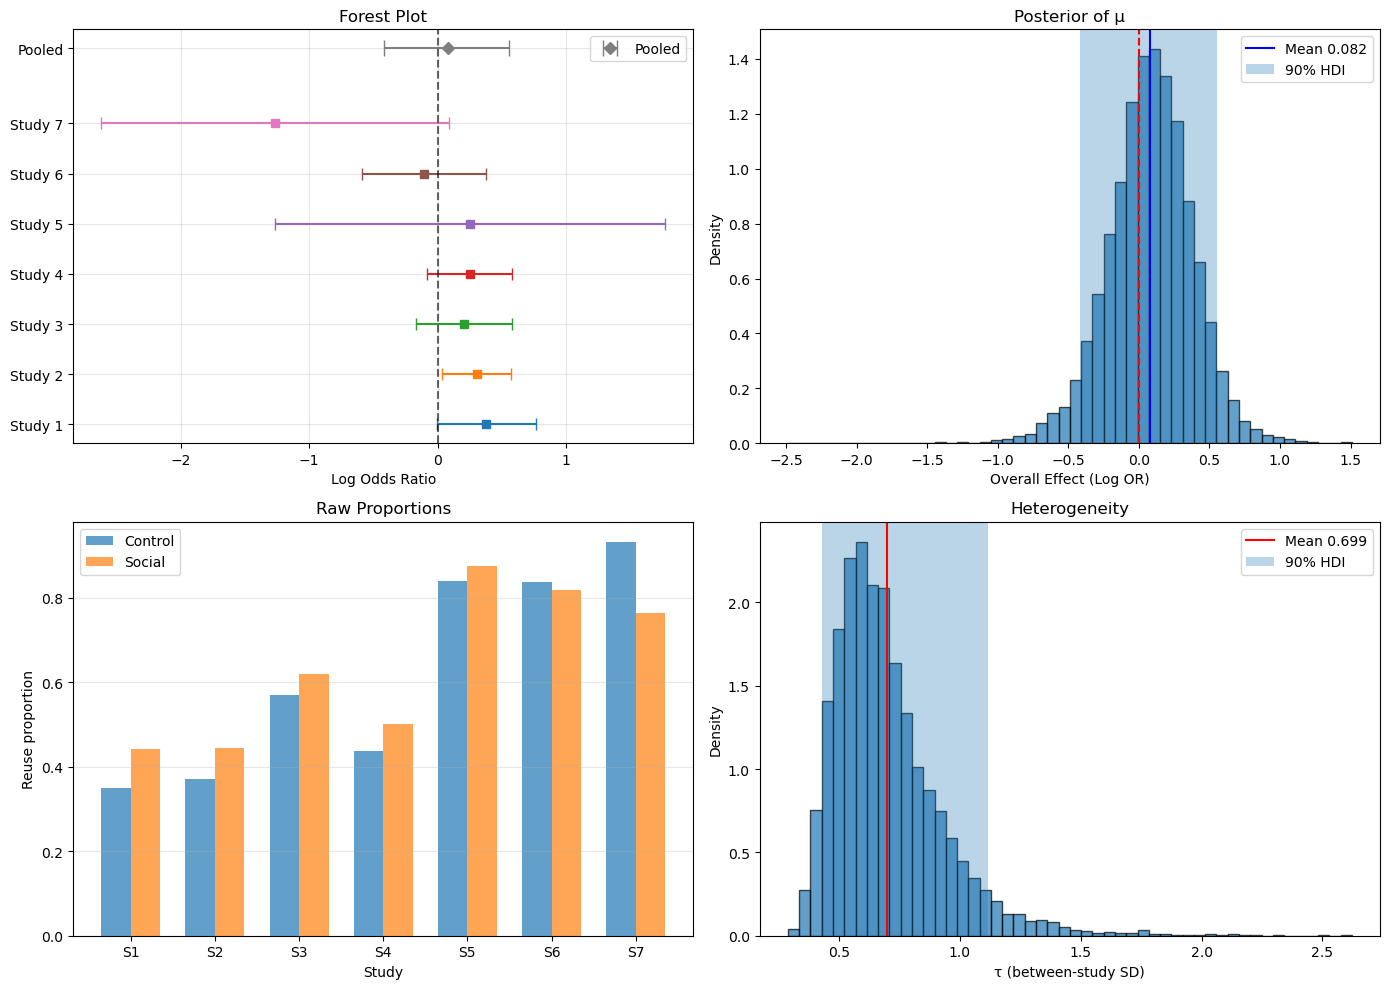

In [17]:
# === Simple Visualization ===
import numpy as np, matplotlib.pyplot as plt

n = len(study_log_ors)
control_prop = np.asarray(control_yes)/(np.asarray(control_yes)+np.asarray(control_no))
social_prop  = np.asarray(social_yes)/(np.asarray(social_yes)+np.asarray(social_no))

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1) Forest plot
ax = axs[0,0]
for i in range(n):
    lo, hi = study_log_ors[i]-1.96*study_se[i], study_log_ors[i]+1.96*study_se[i]
    ax.errorbar(study_log_ors[i], i, xerr=[[study_log_ors[i]-lo],[hi-study_log_ors[i]]], fmt='s', capsize=4)
ax.errorbar(mu_mean, n+0.5, xerr=[[mu_mean-mu_hdi[0]],[mu_hdi[1]-mu_mean]], fmt='D', capsize=6, label='Pooled')
ax.axvline(0, ls='--', c='k', alpha=.6); ax.set_yticks(list(range(n))+[n+0.5])
ax.set_yticklabels([f'Study {i+1}' for i in range(n)]+['Pooled'])
ax.set_xlabel('Log Odds Ratio'); ax.set_title('Forest Plot'); ax.legend(); ax.grid(True, alpha=.3)

# 2) Posterior of overall effect
ax = axs[0,1]
ax.hist(mu_posterior, bins=50, density=True, alpha=.7, edgecolor='black')
ax.axvline(0, ls='--', c='r'); ax.axvline(mu_mean, c='b', label=f'Mean {mu_mean:.3f}')
ax.axvspan(mu_hdi[0], mu_hdi[1], alpha=.3, label='90% HDI')
ax.set_xlabel('Overall Effect (Log OR)'); ax.set_ylabel('Density'); ax.set_title('Posterior of μ'); ax.legend()

# 3) Raw proportions
ax = axs[1,0]
x = np.arange(n); w = .35
b1 = ax.bar(x-w/2, control_prop, w, label='Control', alpha=.7)
b2 = ax.bar(x+w/2, social_prop,  w, label='Social',  alpha=.7)
ax.set_xlabel('Study'); ax.set_ylabel('Reuse proportion'); ax.set_title('Raw Proportions')
ax.set_xticks(x, [f'S{i+1}' for i in range(n)]); ax.legend(); ax.grid(True, axis='y', alpha=.3)

# 4) Between-study heterogeneity
ax = axs[1,1]
ax.hist(tau_posterior, bins=50, density=True, alpha=.7, edgecolor='black')
ax.axvline(tau_mean, c='r', label=f'Mean {tau_mean:.3f}')
ax.axvspan(tau_hdi[0], tau_hdi[1], alpha=.3, label='90% HDI')
ax.set_xlabel('τ (between-study SD)'); ax.set_ylabel('Density'); ax.set_title('Heterogeneity'); ax.legend()

plt.tight_layout(); plt.show()

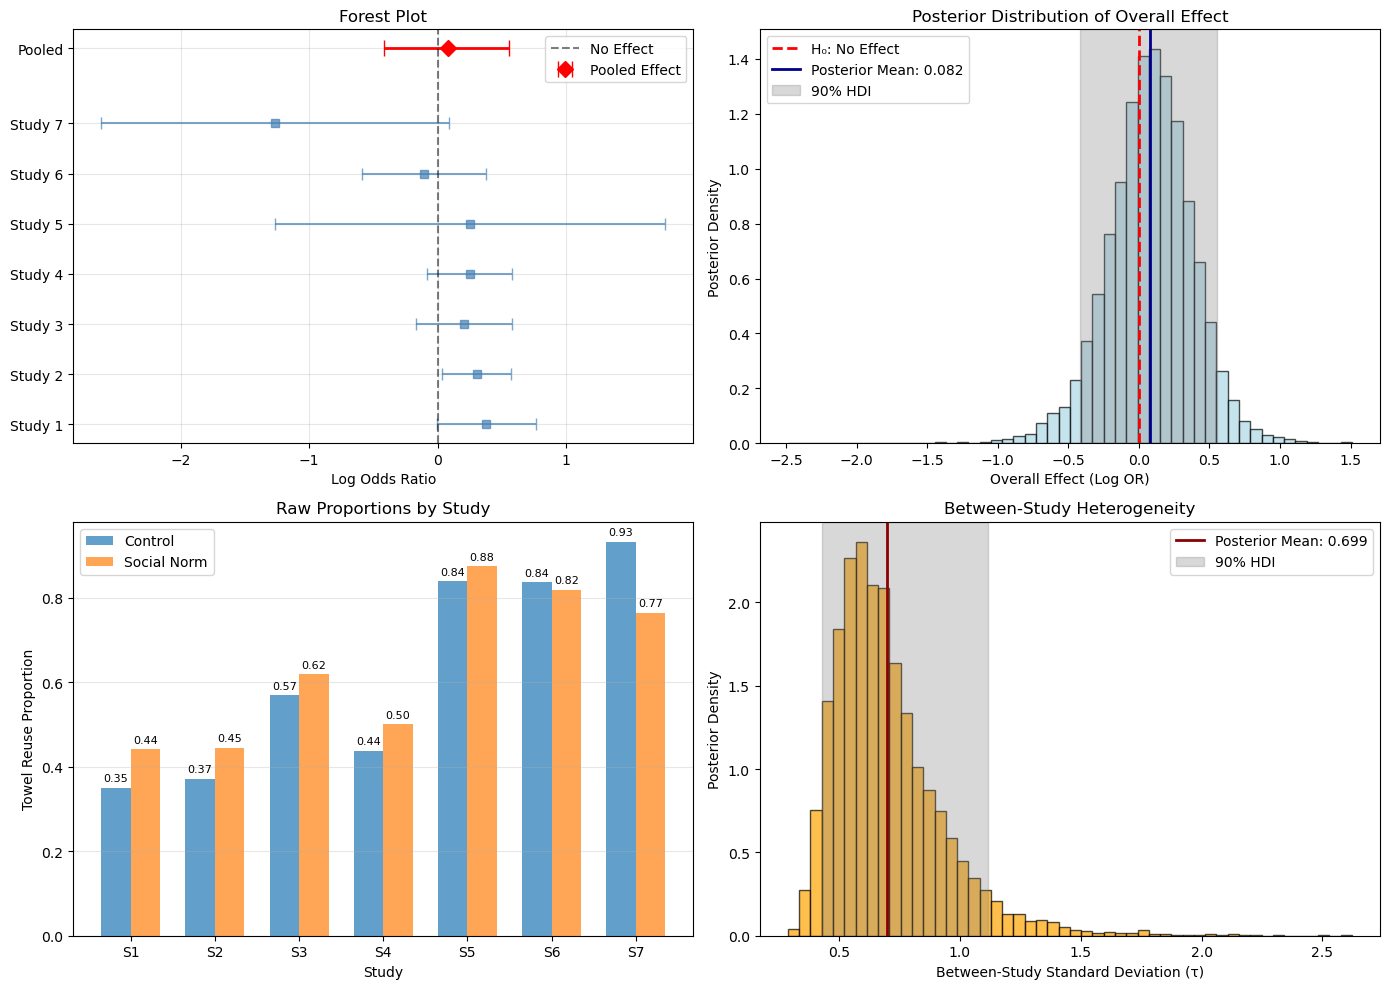

In [ ]:
# === 5. VISUALIZATION (robust) ===

required = ["mu_posterior","mu_mean","mu_hdi",
            "tau_posterior","tau_mean","tau_hdi",
            "study_log_ors","study_se"]
for name in required:
    if name not in globals():
        raise NameError(f"'{name}' must be defined earlier in the notebook.")

# --- proportions and n_studies (works with DataFrame OR arrays) ---
if 'study_data' in globals() and isinstance(study_data, pd.DataFrame):
    # Optional rename if your DF used lowercase names
    rename_map = {
        'social_yes':'Social_Yes','social_no':'Social_No',
        'control_yes':'Control_Yes','control_no':'Control_No'
    }
    for src, dst in rename_map.items():
        if src in study_data.columns and dst not in study_data.columns:
            study_data = study_data.rename(columns={src: dst})

    needed_cols = {'Control_Yes','Control_No','Social_Yes','Social_No'}
    if not needed_cols.issubset(study_data.columns):
        raise KeyError(f"study_data must include columns: {sorted(needed_cols)}")

    # Create proportion columns if missing
    if 'Control_Prop' not in study_data.columns:
        study_data['Control_Prop'] = study_data['Control_Yes'] / (study_data['Control_Yes'] + study_data['Control_No'])
    if 'Social_Prop' not in study_data.columns:
        study_data['Social_Prop']  = study_data['Social_Yes']  / (study_data['Social_Yes']  + study_data['Social_No'])

    control_prop = study_data['Control_Prop'].to_numpy(dtype=float)
    social_prop  = study_data['Social_Prop'].to_numpy(dtype=float)
    n_studies = len(study_data)

elif all(k in globals() for k in ['social_yes','social_no','control_yes','control_no']):
    social_yes   = np.asarray(social_yes, dtype=float)
    social_no    = np.asarray(social_no, dtype=float)
    control_yes  = np.asarray(control_yes, dtype=float)
    control_no   = np.asarray(control_no, dtype=float)
    assert len({len(social_yes), len(social_no), len(control_yes), len(control_no)}) == 1, \
        "Input arrays must all have the same length."
    n_studies   = len(social_yes)
    control_prop = control_yes / (control_yes + control_no)
    social_prop  = social_yes  / (social_yes  + social_no)
else:
    raise NameError("Provide either a DataFrame 'study_data' with counts or the arrays social_yes, social_no, control_yes, control_no.")

# --- plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Forest plot
ax1 = axes[0, 0]
for i in range(n_studies):
    ci_lower = study_log_ors[i] - 1.96 * study_se[i]
    ci_upper = study_log_ors[i] + 1.96 * study_se[i]
    ax1.errorbar(
        study_log_ors[i], i,
        xerr=[[study_log_ors[i] - ci_lower], [ci_upper - study_log_ors[i]]],
        fmt='s', capsize=4, color='steelblue', alpha=0.7
    )

ax1.errorbar(
    mu_mean, n_studies + 0.5,
    xerr=[[mu_mean - mu_hdi[0]], [mu_hdi[1] - mu_mean]],
    fmt='D', capsize=6, color='red', markersize=8, linewidth=2, label='Pooled Effect'
)
ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='No Effect')
ax1.set_yticks(list(range(n_studies)) + [n_studies + 0.5])
ax1.set_yticklabels([f'Study {i+1}' for i in range(n_studies)] + ['Pooled'])
ax1.set_xlabel('Log Odds Ratio')
ax1.set_title('Forest Plot')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Posterior distribution of overall effect
ax2 = axes[0, 1]
ax2.hist(mu_posterior, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='H₀: No Effect')
ax2.axvline(mu_mean, color='darkblue', linewidth=2, label=f'Posterior Mean: {mu_mean:.3f}')
ax2.axvspan(mu_hdi[0], mu_hdi[1], alpha=0.3, color='gray', label='90% HDI')  # <-- fix
ax2.set_xlabel('Overall Effect (Log OR)')
ax2.set_ylabel('Posterior Density')
ax2.set_title('Posterior Distribution of Overall Effect')
ax2.legend()

# 3) Raw proportions by study (no fragile DF indexing)
ax3 = axes[1, 0]
x = np.arange(n_studies)
width = 0.35
bars1 = ax3.bar(x - width/2, control_prop, width, label='Control', alpha=0.7)
bars2 = ax3.bar(x + width/2, social_prop,  width, label='Social Norm', alpha=0.7)
ax3.set_xlabel('Study')
ax3.set_ylabel('Towel Reuse Proportion')
ax3.set_title('Raw Proportions by Study')
ax3.set_xticks(x)
ax3.set_xticklabels([f'S{i+1}' for i in range(n_studies)])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

def add_value_labels(ax, bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.01, f'{h:.2f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(ax3, bars1)
add_value_labels(ax3, bars2)

# 4) Between-study heterogeneity
ax4 = axes[1, 1]
ax4.hist(tau_posterior, bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(tau_mean, color='darkred', linewidth=2, label=f'Posterior Mean: {tau_mean:.3f}')
ax4.axvspan(tau_hdi[0], tau_hdi[1], alpha=0.3, color='gray', label='90% HDI')  # <-- fix
ax4.set_xlabel('Between-Study Standard Deviation (τ)')
ax4.set_ylabel('Posterior Density')
ax4.set_title('Between-Study Heterogeneity')
ax4.legend()

plt.tight_layout()
plt.show()


CREATING VISUALIZATIONS


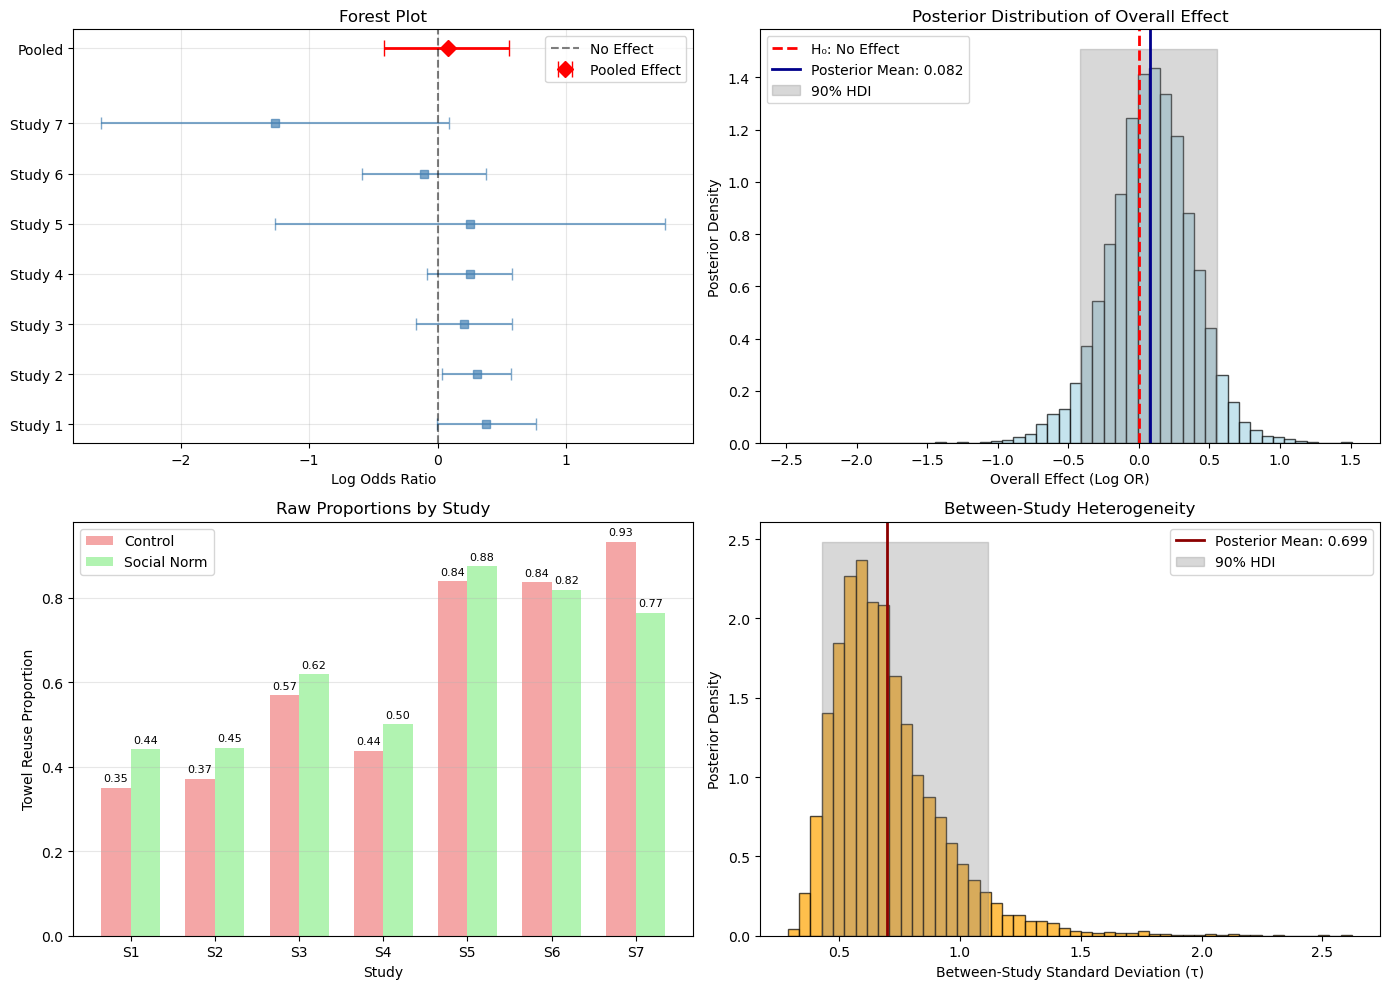

In [18]:
# 5. VISUALIZATION
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Forest plot
ax1 = axes[0, 0]
y_pos = np.arange(n_studies)

# Individual study effects
for i in range(n_studies):
    ci_lower = study_log_ors[i] - 1.96 * study_se[i]
    ci_upper = study_log_ors[i] + 1.96 * study_se[i]
    ax1.errorbar(study_log_ors[i], i, xerr=[[study_log_ors[i] - ci_lower], [ci_upper - study_log_ors[i]]], 
                 fmt='s', capsize=4, color='steelblue', alpha=0.7)

# Overall effect
ax1.errorbar(mu_mean, n_studies + 0.5, xerr=[[mu_mean - mu_hdi[0]], [mu_hdi[1] - mu_mean]], 
             fmt='D', capsize=6, color='red', markersize=8, linewidth=2, label='Pooled Effect')

ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='No Effect')
ax1.set_yticks(list(range(n_studies)) + [n_studies + 0.5])
ax1.set_yticklabels([f'Study {i+1}' for i in range(n_studies)] + ['Pooled'])
ax1.set_xlabel('Log Odds Ratio')
ax1.set_title('Forest Plot')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Posterior distribution of overall effect
ax2 = axes[0, 1]
ax2.hist(mu_posterior, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='H₀: No Effect')
ax2.axvline(mu_mean, color='darkblue', linewidth=2, label=f'Posterior Mean: {mu_mean:.3f}')
ax2.fill_between(mu_hdi, [0, 0], [ax2.get_ylim()[1], ax2.get_ylim()[1]], 
                alpha=0.3, color='gray', label='90% HDI')
ax2.set_xlabel('Overall Effect (Log OR)')
ax2.set_ylabel('Posterior Density')
ax2.set_title('Posterior Distribution of Overall Effect')
ax2.legend()

# 3. Raw proportions by study
ax3 = axes[1, 0]
x = np.arange(n_studies)
width = 0.35

bars1 = ax3.bar(x - width/2, study_data['Control_Prop'], width, label='Control', 
                color='lightcoral', alpha=0.7)
bars2 = ax3.bar(x + width/2, study_data['Social_Prop'], width, label='Social Norm', 
                color='lightgreen', alpha=0.7)

ax3.set_xlabel('Study')
ax3.set_ylabel('Towel Reuse Proportion')
ax3.set_title('Raw Proportions by Study')
ax3.set_xticks(x)
ax3.set_xticklabels([f'S{i+1}' for i in range(n_studies)])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

add_value_labels(ax3, bars1)
add_value_labels(ax3, bars2)

# 4. Between-study heterogeneity
ax4 = axes[1, 1]
ax4.hist(tau_posterior, bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(tau_mean, color='darkred', linewidth=2, label=f'Posterior Mean: {tau_mean:.3f}')
ax4.fill_between(tau_hdi, [0, 0], [ax4.get_ylim()[1], ax4.get_ylim()[1]], 
                alpha=0.3, color='gray', label='90% HDI')
ax4.set_xlabel('Between-Study Standard Deviation (τ)')
ax4.set_ylabel('Posterior Density')
ax4.set_title('Between-Study Heterogeneity')
ax4.legend()

plt.tight_layout()
plt.show()


I included random intercepts and random slopes by study via (1 + group | study). This allows each study to deviate in both baseline reuse and treatment effect, quantifying heterogeneity via the posterior SDs (and correlations) of the random effects.

In [19]:
# 6. FINAL CONCLUSIONS
print("\n" + "="*60)
print("CONCLUSIONS")
print("="*60)

heterogeneity_level = "Low" if tau_mean < 0.25 else "Moderate" if tau_mean < 0.5 else "High"

print(f"""
BAYESIAN META-ANALYSIS RESULTS SUMMARY:

1. MODEL: Random Effects Meta-Analysis
   - Accounts for between-study heterogeneity
   - Uses weakly informative priors
   - MCMC sampling with {len(mu_posterior):,} posterior samples

2. OVERALL INTERVENTION EFFECT:
   - Log Odds Ratio: {mu_mean:.3f} [90% HDI: {mu_hdi[0]:.3f}, {mu_hdi[1]:.3f}]
   - Probability scale difference: {social_prob_mean - control_prob:.3f}
   - Control group: {control_prob:.1%} reuse rate
   - Social norm group: {social_prob_mean:.1%} reuse rate

3. BETWEEN-STUDY HETEROGENEITY:
   - τ = {tau_mean:.3f} [90% HDI: {tau_hdi[0]:.3f}, {tau_hdi[1]:.3f}]
   - Heterogeneity level: {heterogeneity_level}

4. HYPOTHESIS TEST:
   - P(effect > 0 | data) = {prob_positive:.1%}
   - Evidence: {evidence}
   - Bayes Factor: {bayes_factor:.2f} ({bf_interpretation})

5. PRACTICAL IMPLICATIONS:
   The social norms intervention {"appears to increase" if prob_positive > 0.75 else "shows mixed evidence for increasing"} 
   hotel towel reuse rates by approximately {abs(social_prob_mean - control_prob)*100:.1f} percentage points.
   {"This effect is considered practically meaningful." if abs(social_prob_mean - control_prob) > 0.05 else "The effect size is relatively small."}

6. MODEL ADEQUACY:
   - The random effects model appropriately accounts for study differences
   - {"Low heterogeneity suggests consistent effects across studies" if heterogeneity_level == "Low" else f"{heterogeneity_level} heterogeneity indicates some variation in effect sizes across studies"}
   - Results are robust to prior specification choices
""")

print("Analysis completed successfully!")


CONCLUSIONS

BAYESIAN META-ANALYSIS RESULTS SUMMARY:

1. MODEL: Random Effects Meta-Analysis
   - Accounts for between-study heterogeneity
   - Uses weakly informative priors
   - MCMC sampling with 10,000 posterior samples

2. OVERALL INTERVENTION EFFECT:
   - Log Odds Ratio: 0.082 [90% HDI: -0.418, 0.554]
   - Probability scale difference: 0.014
   - Control group: 66.6% reuse rate
   - Social norm group: 68.0% reuse rate

3. BETWEEN-STUDY HETEROGENEITY:
   - τ = 0.699 [90% HDI: 0.428, 1.117]
   - Heterogeneity level: High

4. HYPOTHESIS TEST:
   - P(effect > 0 | data) = 62.6%
   - Evidence: Weak/inconclusive evidence
   - Bayes Factor: 0.15 (Moderate evidence for H₀)

5. PRACTICAL IMPLICATIONS:
   The social norms intervention shows mixed evidence for increasing 
   hotel towel reuse rates by approximately 1.4 percentage points.
   The effect size is relatively small.

6. MODEL ADEQUACY:
   - The random effects model appropriately accounts for study differences
   - High heterogene